In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda")

# Import our models. The package will take care of downloading the models automatically

model_name = "NousResearch/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/workspace/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.83s/it]
/workspace/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/workspace/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in samp

In [2]:
from datasets import load_dataset

dataset = load_dataset("cais/mmlu", 'all', split='test')

In [3]:
df = dataset.to_pandas()

In [4]:
subjects = df['subject'].unique()

def get_subject(subject, max):
    group = df[df['subject'] == subject].sample(max)
    return group

In [5]:
prompt_template="""
<s>[INST] <<SYS>>
Answer the following question.
<</SYS>>
{question}
A. {answer_a}
B. {answer_b}
C. {answer_c}
D. {answer_d}
[/INST]
The correct answer is: {correct_answer}
""".strip()

In [6]:
answer_choices = ['A', 'B', 'C', 'D']

def generate_prompts(subject, max=100):
    prompts = []
    correct_answers = []

    for row in get_subject(subject, max=max).iterrows():
        row = row[1]
        question = row['question']
        answers = row['choices']
        correct_answer = row['answer']
        if len(answers) != 4:
            print("Skipping question with {} answers".format(len(answers)))
            continue
        answer_a = answers[0]
        answer_b = answers[1]
        answer_c = answers[2]
        answer_d = answers[3]

        prompt = prompt_template.format(question=question, answer_a=answer_a, answer_b=answer_b, answer_c=answer_c, answer_d=answer_d, correct_answer=correct_answer)
        prompts.append(prompt)

        correct_answers.append(correct_answer)

    return prompts, correct_answers

In [7]:
answer_tokens = [319, 350, 315, 360]
# answer_tokens = tokenizer(answer_choices, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

In [8]:
from tqdm import tqdm

def test(prompts, correct_answers):
    correct = 0
    total = 0

    for i, prompt in enumerate(prompts):
        input = tokenizer.encode(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model(input)
        logits = output.logits[0, -2]

        corret_answer = correct_answers[i]

        top10 = torch.topk(logits, 10)
        top10_tokens = top10.indices
        answer_logits = []
        for token in answer_tokens:
            answer_logits.append(logits[token].item())
        predicted_answer = answer_logits.index(max(answer_logits))
        if predicted_answer == corret_answer:
            correct += 1

        total += 1
        # pbar.set_description("Accuracy: {:.2f}%".format(correct / total * 100))

    return correct / total

In [9]:
for p in model.model.parameters():
    p.requires_grad = False

In [10]:
def purge(layers):
    weights = []
    for layer in layers:
        weight = model.model.layers[layer].self_attn.v_proj.weight.detach().clone()
        weights.append(weight)
        model.model.layers[layer].self_attn.v_proj.weight.zero_()

    return weights

def restore(layers, weights):
    for layer, weight in zip(layers, weights):
        model.model.layers[layer].self_attn.v_proj.weight = torch.nn.Parameter(weight, requires_grad=False)

In [11]:
def run_test(subject, layers=[]):
    weights = purge(layers)
    try:
        prompts, correct_answers = generate_prompts(subject)
        accuracy = test(prompts, correct_answers)
    finally:
        restore(layers, weights)

    return accuracy

In [12]:
import requests
url = "https://discord.com/api/webhooks/1194788894735093790/zuPqRXGOXIdLs1Js-eUbPiEzYPqL5gZlHSpOsrCewYXONU8SBfoFWrY6bXM6E4RQ_kLh"
def send_to_discord(content):
    data = {
        "username": "python",
        "content": content
    }

    result = requests.post(url, json=data)

    try:
        result.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
    else:
        print("Payload delivered successfully, code {}.".format(result.status_code))

In [13]:
def send_scores(scores, test_index, message):
    content = [
        f'{subject}: {accuracy * 100:.0f}%' for subject, accuracy in zip(subjects, scores)
    ]
    content = '\n'.join(content)
    content = f"***Test{test_index}***" + "\n" + f"Description: {message}" + "\n" + content
    send_to_discord(content)

In [14]:
import torch.nn as nn

# Test1: normal
test1_scores = []
for subject in subjects:
    accuracy = run_test(subject)
    test1_scores.append(accuracy)
    print("Subject: {}, Accuracy: {:.2f}%".format(subject, accuracy * 100))

send_scores(test1_scores, test_index=1, message="Normal Model Brain")

Subject: high_school_government_and_politics, Accuracy: 73.00%
Subject: security_studies, Accuracy: 49.00%
Subject: global_facts, Accuracy: 39.00%
Subject: sociology, Accuracy: 71.00%
Subject: high_school_european_history, Accuracy: 65.00%
Subject: college_biology, Accuracy: 50.00%
Subject: high_school_psychology, Accuracy: 65.00%
Subject: astronomy, Accuracy: 42.00%
Subject: electrical_engineering, Accuracy: 43.00%
Subject: logical_fallacies, Accuracy: 59.00%
Subject: nutrition, Accuracy: 50.00%
Subject: high_school_biology, Accuracy: 51.00%
Subject: high_school_macroeconomics, Accuracy: 45.00%
Subject: virology, Accuracy: 43.00%
Subject: machine_learning, Accuracy: 37.00%
Subject: jurisprudence, Accuracy: 55.00%
Subject: professional_psychology, Accuracy: 45.00%
Subject: abstract_algebra, Accuracy: 29.00%
Subject: econometrics, Accuracy: 28.00%
Subject: high_school_mathematics, Accuracy: 29.00%
Subject: high_school_computer_science, Accuracy: 43.00%
Subject: philosophy, Accuracy: 63.

In [15]:
# Test2: remove first layer
test2_scores = []
for subject in subjects:
    accuracy = run_test(subject, layers=[0])
    test2_scores.append(accuracy)
    print("Subject: {}, Accuracy: {:.2f}%".format(subject, accuracy * 100))

send_scores(test2_scores, test_index=2, message = "Model Brain with first layer removed")

Subject: high_school_government_and_politics, Accuracy: 16.00%
Subject: security_studies, Accuracy: 15.00%
Subject: global_facts, Accuracy: 17.00%
Subject: sociology, Accuracy: 27.00%
Subject: high_school_european_history, Accuracy: 26.00%
Subject: college_biology, Accuracy: 21.00%
Subject: high_school_psychology, Accuracy: 24.00%
Subject: astronomy, Accuracy: 20.00%
Subject: electrical_engineering, Accuracy: 30.00%
Subject: logical_fallacies, Accuracy: 19.00%
Subject: nutrition, Accuracy: 25.00%
Subject: high_school_biology, Accuracy: 21.00%
Subject: high_school_macroeconomics, Accuracy: 30.00%
Subject: virology, Accuracy: 29.00%
Subject: machine_learning, Accuracy: 31.00%
Subject: jurisprudence, Accuracy: 29.00%
Subject: professional_psychology, Accuracy: 29.00%
Subject: abstract_algebra, Accuracy: 18.00%
Subject: econometrics, Accuracy: 25.00%
Subject: high_school_mathematics, Accuracy: 22.00%
Subject: high_school_computer_science, Accuracy: 23.00%
Subject: philosophy, Accuracy: 18.

In [16]:
# Test3: remove last layer
test3_scores = []
for subject in subjects:
    accuracy = run_test(subject, layers=[11])
    test3_scores.append(accuracy)
    print("Subject: {}, Accuracy: {:.2f}%".format(subject, accuracy * 100))

send_scores(test3_scores, test_index=3, message = "Model Brain with last layer removed")

Subject: high_school_government_and_politics, Accuracy: 64.00%
Subject: security_studies, Accuracy: 53.00%
Subject: global_facts, Accuracy: 35.00%
Subject: sociology, Accuracy: 75.00%
Subject: high_school_european_history, Accuracy: 64.00%
Subject: college_biology, Accuracy: 46.00%
Subject: high_school_psychology, Accuracy: 54.00%
Subject: astronomy, Accuracy: 46.00%
Subject: electrical_engineering, Accuracy: 45.00%
Subject: logical_fallacies, Accuracy: 55.00%
Subject: nutrition, Accuracy: 56.00%
Subject: high_school_biology, Accuracy: 47.00%
Subject: high_school_macroeconomics, Accuracy: 38.00%
Subject: virology, Accuracy: 51.00%
Subject: machine_learning, Accuracy: 38.00%
Subject: jurisprudence, Accuracy: 49.00%
Subject: professional_psychology, Accuracy: 40.00%
Subject: abstract_algebra, Accuracy: 32.00%
Subject: econometrics, Accuracy: 30.00%
Subject: high_school_mathematics, Accuracy: 24.00%
Subject: high_school_computer_science, Accuracy: 47.00%
Subject: philosophy, Accuracy: 43.

In [17]:
# Test4: remove last 8 layers
test4_scores = []
for subject in subjects:
    accuracy = run_test(subject, layers=[24, 25, 26, 27, 28, 29, 30, 31])
    test4_scores.append(accuracy)
    print("Subject: {}, Accuracy: {:.2f}%".format(subject, accuracy * 100))

send_scores(test4_scores, test_index=4, message = "Model Brain with last 8 layers removed")

Subject: high_school_government_and_politics, Accuracy: 72.00%
Subject: security_studies, Accuracy: 50.00%
Subject: global_facts, Accuracy: 44.00%
Subject: sociology, Accuracy: 72.00%
Subject: high_school_european_history, Accuracy: 66.00%
Subject: college_biology, Accuracy: 53.00%
Subject: high_school_psychology, Accuracy: 59.00%
Subject: astronomy, Accuracy: 40.00%
Subject: electrical_engineering, Accuracy: 47.00%
Subject: logical_fallacies, Accuracy: 67.00%
Subject: nutrition, Accuracy: 46.00%
Subject: high_school_biology, Accuracy: 53.00%
Subject: high_school_macroeconomics, Accuracy: 47.00%
Subject: virology, Accuracy: 49.00%
Subject: machine_learning, Accuracy: 37.00%
Subject: jurisprudence, Accuracy: 56.00%
Subject: professional_psychology, Accuracy: 46.00%
Subject: abstract_algebra, Accuracy: 29.00%
Subject: econometrics, Accuracy: 33.00%
Subject: high_school_mathematics, Accuracy: 24.00%
Subject: high_school_computer_science, Accuracy: 46.00%
Subject: philosophy, Accuracy: 58.

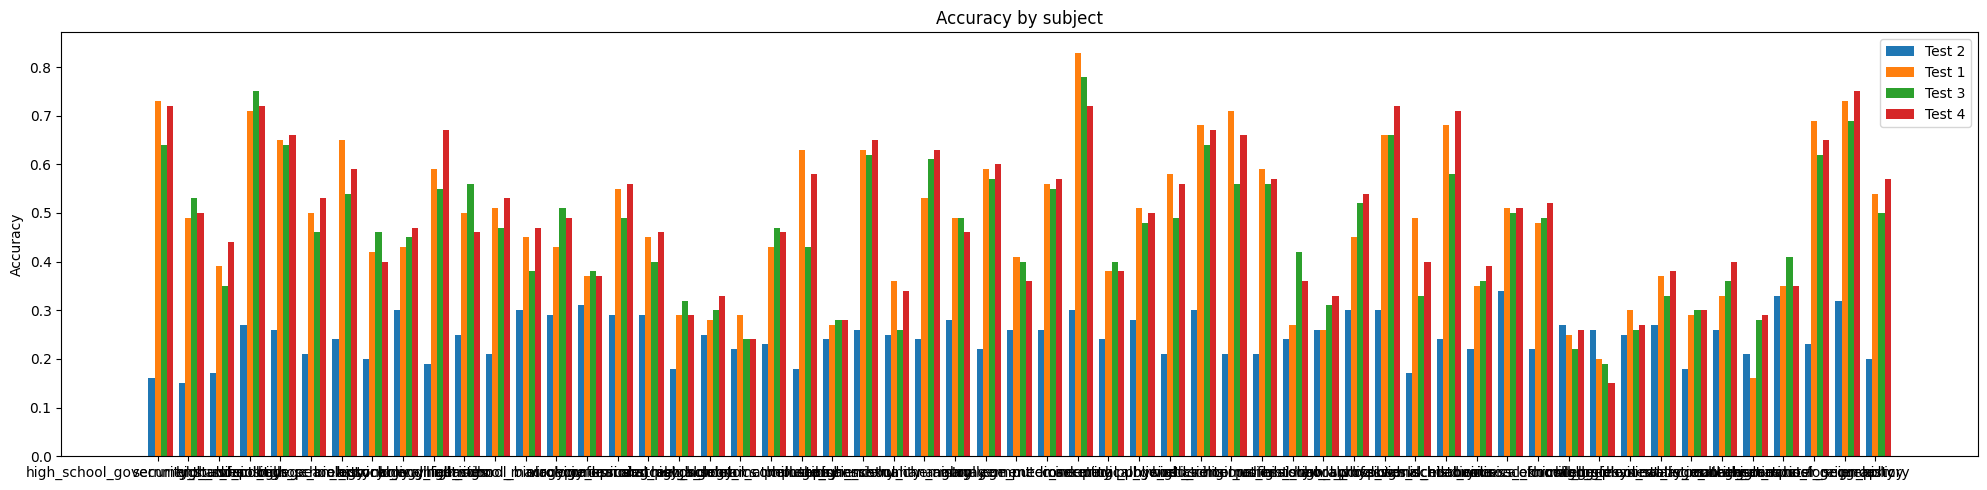

In [21]:
# bar chart
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(subjects))
width = 0.2

fig, ax = plt.subplots((1), figsize=(20, 5))
rects1 = ax.bar(x - width, test2_scores, width, label='Test 2')
rects2 = ax.bar(x, test1_scores, width, label='Test 1')
rects3 = ax.bar(x + width, test3_scores, width, label='Test 3')
rects4 = ax.bar(x + width * 2, test4_scores, width, label='Test 4')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by subject')
ax.set_xticks(x)
ax.set_xticklabels(subjects)
ax.legend()

fig.tight_layout()

plt.show()